<a href="https://colab.research.google.com/github/uplus26e7/pytorch-programming-introduction/blob/master/%E5%8B%95%E3%81%8B%E3%81%97%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6_PyTorch_%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E5%85%A5%E9%96%80_Chapter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_diabetes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

# Section 2 アヤメの分類【サンプルコード】

## Section 2.1 アヤメ(Iris)データセット

In [2]:
iris = load_iris()

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
df["Variety"] = iris.target
df.loc[df["Variety"] == 0, "Variety"] = "setosa"
df.loc[df["Variety"] == 1, "Variety"] = "versicolor"
df.loc[df["Variety"] == 2, "Variety"] = "virginica"
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Variety
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [6]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


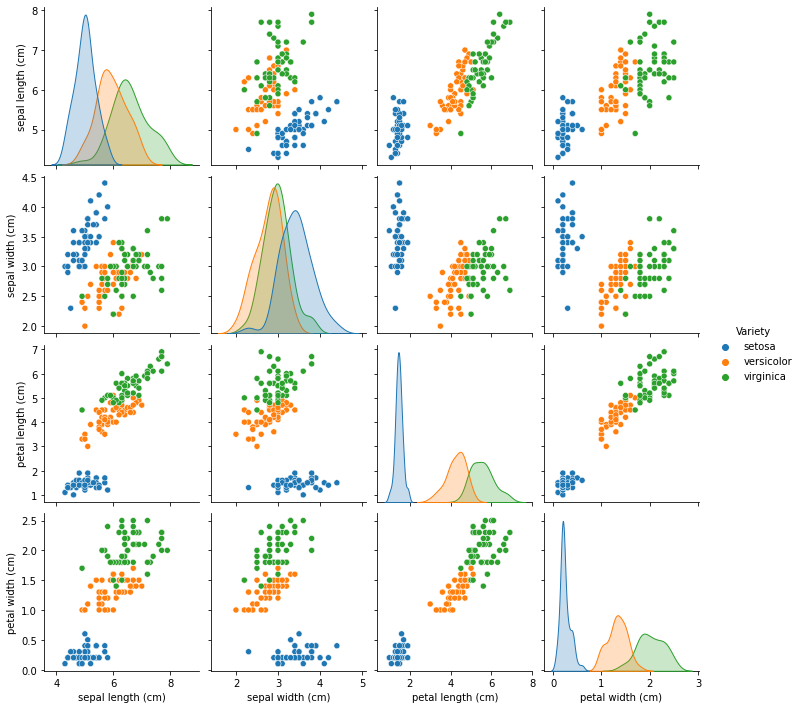

In [7]:
sns.pairplot(df, hue="Variety")
plt.show()

## Section 2.2 前準備(パッケージのインポート)

In [8]:
data = iris.data
label = iris.target

## Section 2.3 訓練データとテストデータの用意

In [9]:
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2
)

In [10]:
train_data.shape, test_data.shape, train_label.shape, test_label.shape

((120, 4), (30, 4), (120,), (30,))

In [11]:
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.LongTensor(train_label)
test_y = torch.LongTensor(test_label)

In [12]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [13]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=5,
    shuffle=True,
    num_workers=2
)

test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=5,
    shuffle=True,
    num_workers=2
)

In [14]:
for data, label in train_batch:
  print(f"batch data size: {data.size()}")
  print(f"batch label size: {label.size()}")
  break

batch data size: torch.Size([5, 4])
batch label size: torch.Size([5])


## Section 2.4 ニューラルネットワークの定義

In [15]:
class Net(nn.Module):
  def __init__(self, D_in, H, D_out):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, D_out)
  
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [16]:
D_in = 4
H = 100
D_out = 3
epoch = 100

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
net = Net(D_in, H, D_out).to(device)

In [19]:
device

device(type='cpu')

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

## Section 2.6 学習

In [21]:
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  train_accuracy = 0
  test_loss = 0
  test_accuracy = 0

  # train part
  net.train()
  for data, label in train_batch:
    data = data.to(device)
    label = label.to(device)

    optimizer.zero_grad()

    y_pred_prob = net(data)
    loss = criterion(y_pred_prob, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    y_pred_label = torch.max(y_pred_prob, 1)[1]
    train_accuracy += torch.sum(y_pred_label == label).item() / len(label)
  
  batch_train_loss = train_loss / len(train_batch)
  batch_train_accuracy = train_accuracy / len(train_batch)

  # eval part
  net.eval()
  
  with torch.no_grad():
    for data, label in test_batch:
      data = data.to(device)
      label = label.to(device)

      y_pred_prob = net(data)
      loss = criterion(y_pred_prob, label)
      test_loss += loss.item()

      y_pred_label = torch.max(y_pred_prob, 1)[1]
      test_accuracy += torch.sum(y_pred_label == label).item() / len(label)
  
  batch_test_loss = test_loss / len(test_batch)
  batch_test_accuracy = test_accuracy / len(test_batch)

  print(f"Train_Loss: {batch_train_loss:.4f} Train_Accuracy: {batch_train_accuracy:.4f}")
  print(f"Test_Loss: {batch_test_loss:.4f} Test_Accuracy: {batch_test_accuracy:.4f}")

  train_loss_list.append(batch_train_loss)
  train_accuracy_list.append(batch_train_accuracy)
  test_loss_list.append(batch_test_loss)
  test_accuracy_list.append(batch_test_accuracy)

----------------------------------------------------------------------------------------------------
Epoch: 1/100
Train_Loss: 1.1407 Train_Accuracy: 0.3667
Test_Loss: 0.9334 Test_Accuracy: 0.4667
----------------------------------------------------------------------------------------------------
Epoch: 2/100
Train_Loss: 0.9563 Train_Accuracy: 0.4750
Test_Loss: 0.9108 Test_Accuracy: 0.5333
----------------------------------------------------------------------------------------------------
Epoch: 3/100
Train_Loss: 0.8234 Train_Accuracy: 0.6417
Test_Loss: 0.7109 Test_Accuracy: 0.8667
----------------------------------------------------------------------------------------------------
Epoch: 4/100
Train_Loss: 0.6987 Train_Accuracy: 0.7750
Test_Loss: 0.5911 Test_Accuracy: 0.8000
----------------------------------------------------------------------------------------------------
Epoch: 5/100
Train_Loss: 0.6041 Train_Accuracy: 0.8667
Test_Loss: 0.5363 Test_Accuracy: 0.8333
--------------------

## Section 2.7 結果の可視化

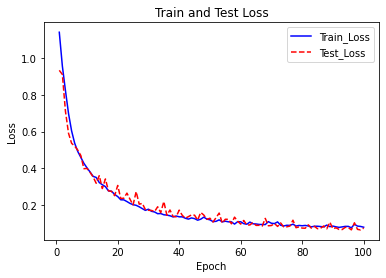

In [22]:
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, epoch + 1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch + 1), test_loss_list, color="red", linestyle="--", label="Test_Loss")
plt.legend()
plt.show()

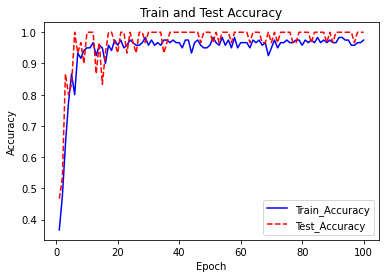

In [23]:
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, epoch + 1), train_accuracy_list, color="blue", linestyle="-", label="Train_Accuracy")
plt.plot(range(1, epoch + 1), test_accuracy_list, color="red", linestyle="--", label="Test_Accuracy")
plt.legend()
plt.show()

## Section 2.8 新たにテスト用のデータセットを用意して推定したい場合

In [24]:
torch.save(net.to(device).state_dict(), '3-2_iris_net.pth')

In [25]:
net2 = Net(D_in, H, D_out).to(device)
net2.load_state_dict(torch.load("3-2_iris_net.pth", map_location=device))
net2

Net(
  (linear1): Linear(in_features=4, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=3, bias=True)
)

In [26]:
net2.eval()

with torch.no_grad():
  test_accuracy = 0
  for data, label in test_batch:
    data = data.to(device)
    label = label.to(device)
    y_pred_prob = net(data)
    y_pred_label = torch.max(y_pred_prob, 1)[1]
    test_accuracy += torch.sum(y_pred_label == label).item() / len(label)

batch_test_accuracy = test_accuracy / len(test_batch)
print(f"Accuracy: {batch_test_accuracy:.4f}")

Accuracy: 1.0000


# Section 3 糖尿病の予後予測【サンプルコード】

In [27]:
diabetes = load_diabetes()

In [28]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [29]:
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["target"] = diabetes.target
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [30]:
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01,346.000000


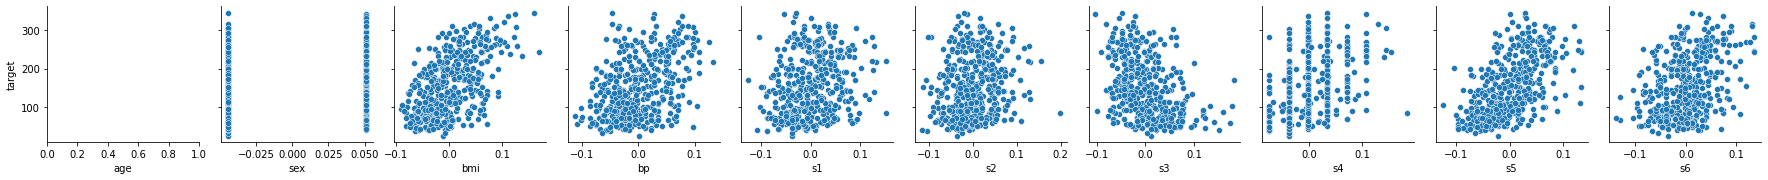

In [31]:
sns.pairplot(df, x_vars=diabetes.feature_names, y_vars="target")

## Section 3.2 前準備(パッケージのインポート)

In [32]:
data = diabetes.data
label = diabetes.target.reshape(-1, 1)

data.shape, label.shape

((442, 10), (442, 1))

## Section 3.3 訓練データとテストデータの用意

In [33]:
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2
)

train_data.shape, test_data.shape, train_label.shape, test_label.shape

((353, 10), (89, 10), (353, 1), (89, 1))

In [34]:
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)
test_y = torch.Tensor(test_label)

In [35]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [36]:
train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=20,
    shuffle=True,
    num_workers=2
)

test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=20,
    shuffle=False,
    num_workers=2
)

for data, label in train_batch:
  print(f"batch data size: {data.size()}")
  print(f"batch label size: {label.size()}")
  break

batch data size: torch.Size([20, 10])
batch label size: torch.Size([20, 1])


## Section 3.4 ニューラルネットワークの定義

In [37]:
class Net(nn.Module):
  def __init__(self, D_in, H, D_out):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, H)
    self.linear3 = nn.Linear(H, D_out)
    self.dropout = nn.Dropout(p=0.5)
  
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear2(x))
    x = self.dropout(x)
    x = self.linear3(x)
    return x

In [38]:
D_in = 10
H = 200
D_out = 1
epoch = 100

In [39]:
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [40]:
net = Net(D_in, H, D_out)
net

Net(
  (linear1): Linear(in_features=10, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Section 3.5 損失関数と最適化関数の定義

In [41]:
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()

optimizer = optim.Adam(net.parameters())

## Section 3.6 学習

In [42]:
train_loss_list = []
train_mae_list = []
test_loss_list = []
test_mae_list = []

for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  train_mae = 0
  test_loss = 0
  test_mae = 0

  # train part
  net.train()
  for data, label in train_batch:
    data = data.to(device)
    label = label.to(device)

    optimizer.zero_grad()

    y_pred = net(data)
    loss = criterion(y_pred, label)
    mae = criterion2(y_pred, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_mae += mae.item()
  
  batch_train_loss = train_loss / len(train_batch)
  batch_train_mae = train_mae / len(train_batch)

  # eval part
  net.eval()
  
  with torch.no_grad():
    for data, label in test_batch:
      data = data.to(device)
      label = label.to(device)

      y_pred = net(data)
      loss = criterion(y_pred, label)
      mae = criterion2(y_pred, label)

      test_loss += loss.item()
      test_mae += mae.item()
  
  batch_test_loss = test_loss / len(test_batch)
  batch_test_mae = test_mae / len(test_batch)

  print(f"Train_Loss: {batch_train_loss:.4f} Train_MAE: {batch_train_mae:.4f}")
  print(f"Test_Loss: {batch_test_loss:.4f} Test_MAE: {batch_test_mae:.4f}")

  train_loss_list.append(batch_train_loss)
  train_mae_list.append(batch_train_mae)
  test_loss_list.append(batch_test_loss)
  test_mae_list.append(batch_test_mae)

----------------------------------------------------------------------------------------------------
Epoch: 1/100
Train_Loss: 28629.2053 Train_MAE: 150.9655
Test_Loss: 28000.4750 Test_MAE: 148.1119
----------------------------------------------------------------------------------------------------
Epoch: 2/100
Train_Loss: 26820.1243 Train_MAE: 144.8391
Test_Loss: 23630.8424 Test_MAE: 132.7731
----------------------------------------------------------------------------------------------------
Epoch: 3/100
Train_Loss: 18228.2825 Train_MAE: 111.7304
Test_Loss: 10679.4427 Test_MAE: 79.6307
----------------------------------------------------------------------------------------------------
Epoch: 4/100
Train_Loss: 6665.3529 Train_MAE: 67.2437
Test_Loss: 5454.4469 Test_MAE: 62.9837
----------------------------------------------------------------------------------------------------
Epoch: 5/100
Train_Loss: 5064.8283 Train_MAE: 60.4393
Test_Loss: 4847.4945 Test_MAE: 57.7349
-------------------

## Section 3.7 結果の可視化

In [43]:
len(train_loss_list)

100

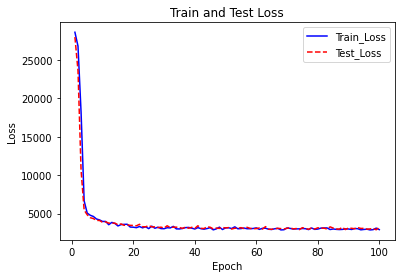

In [44]:
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch + 1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch + 1), test_loss_list, color="red", linestyle="--", label="Test_Loss")
plt.legend()
plt.show()

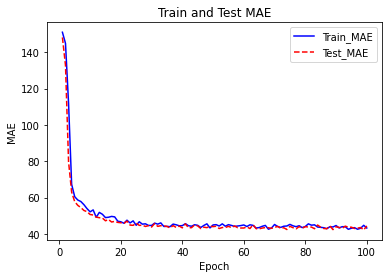

In [45]:
plt.figure()
plt.title('Train and Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(range(1, epoch + 1), train_mae_list, color="blue", linestyle="-", label="Train_MAE")
plt.plot(range(1, epoch + 1), test_mae_list, color="red", linestyle="--", label="Test_MAE")
plt.legend()
plt.show()